# Зоопарк моделей

Внутри Tensorflow лежит довольно большое число предобученных моделей. Давайте попробуем вытащить какую-нибудь модель из его анналов и к чему-нибудь применим её. 

Все эти модели лежат в модуле `keras.applications`. Как правило, это классификаторы изображений, которые обучале на выборке [__IMAGENET.__](http://image-net.org/)


## 1. Я реквизирую эту VGG-16

Давайте заберём себе чужую, уже обученную на ImageNet, сетку VGG-16

<img align="center" src="https://neurohive.io/wp-content/uploads/2018/11/vgg16-neural-network-1-e1542973058418.jpg" width="500">

In [1]:
import requests
import tensorflow.keras.applications as zoo # как зоопарк подгружаем, азазазазаз

In [2]:
model = zoo.VGG16(include_top=True, weights='imagenet')

Опция `weights` отвечает за то, на каком датасете предобучена модель. Опция `include_top` отвечает за то, скачиваем мы модель полностью или только `feature extractor`, то есть только первые слои. Мы скачали всё. 

Давайте посмотрим на `summary` модели и узнаем размерность входа и выхода.

In [3]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Можно выдернуть размерность и не смотря на `summary`.

In [4]:
model.layers[0].output_shape

[(None, 224, 224, 3)]

In [5]:
input_shape = model.layers[0].output_shape[0][1:3]
input_shape

(224, 224)

Теперь попробуем что-нибудь спрогнозировать. В модуле `keras.utis` есть функция `get_file`, которая умеет скачивать и разархивировать разные файлы. Будем использовать её для скачки картинок по ссылкам. 

In [6]:
from tensorflow.keras.utils import get_file

/Users/fulyankin/.keras/datasets/cat.jpg


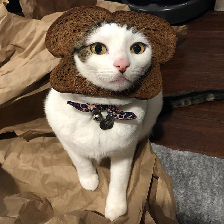

In [7]:
import PIL.Image
import numpy as np

href = 'https://sadanduseless.b-cdn.net/wp-content/uploads/2019/06/cat-breading4.jpg'
image = get_file('cat.jpg', href)

print(image) # куда скачался то?! 

image = PIL.Image.open(image).resize(input_shape)
image 

In [8]:
# немного предобработки
image = np.array(image)/255.0
image.shape

(224, 224, 3)

In [9]:
# вот так можно добавить фиктивную размерность
image[np.newaxis, ...].shape

(1, 224, 224, 3)

In [10]:
# строим прогноз 
result = model.predict(image[np.newaxis, ...])
result.shape

(1, 1000)

Готово! У нас есть $1000$ вариантов прогноза. Если быть более конкретным, нас в случае данного изображения устраивает класс номер

In [11]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

669

In [12]:
result[0].argsort()[-5:][::-1] # топ-5 классов

array([669, 999, 794, 700, 431])

Осталось только выяснить что это за класс. Для этого нам нужны метки Imagenet. Скачаем их. Они тоже уже есть в пакете. Удобно. 

In [13]:
from tensorflow.python.keras.applications.vgg16 import decode_predictions
decode_predictions(result)[0]

[('n03788365', 'mosquito_net', 0.21112208),
 ('n15075141', 'toilet_tissue', 0.08748005),
 ('n04209239', 'shower_curtain', 0.03769085),
 ('n03887697', 'paper_towel', 0.029283682),
 ('n02804414', 'bassinet', 0.023687467)]

Напишем функцию для строительства прогнозов и попробуем ещё. 

In [14]:
import matplotlib.pyplot as plt

def save_image(href, save_name):
    img = get_file(save_name, href)
    return img
    
def predict(image_path):
    # Подгружаем изображение и делаем его ресайз в соответсвии с моделью
    img = PIL.Image.open(image_path)
    
    # тут чуть подрбнее про ресайзы: https://habr.com/ru/post/247219/
    img_resized = img.resize(input_shape, PIL.Image.LANCZOS)

    # Рисуем картинку
    plt.imshow(img_resized)
    plt.show()

    # Кнвертируем картинку в numpy и делаем лишнюю размерность
    img_array = np.array(img_resized)[np.newaxis, ...]

    # VGG-16 строит нам прогноз
    pred = model.predict(img_array)
    
    # Декодируем прогноз
    pred_decoded = decode_predictions(pred)[0]

    # Печатаем его на экран
    for code, name, score in pred_decoded:
        print("{0:>6.2%} : {1}".format(score, name))

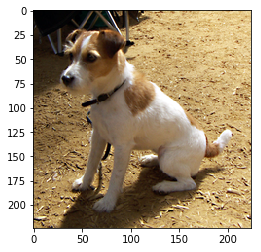

21.06% : American_Staffordshire_terrier
17.63% : Staffordshire_bullterrier
13.81% : toy_terrier
 8.60% : miniature_schnauzer
 8.36% : boxer


In [17]:
href = 'https://upload.wikimedia.org/wikipedia/commons/e/e7/Jack-Russell-Terrier.jpg'
path = save_image(href, 'img_dog.jpg')
predict(path)

In [ ]:
# Ваши картинки 

Обратите внимание, что когда мы делаем `.resize`, мы используем опцию `PIL.Image.LANCZOS` она делает кое-какие приятные ништяки, связанные с защитой изображения от искажений. Вообще борьба с искажениями и разными размерностями у картинок - один из этапов предобработки. 

Как добиться того, чтобы картинка не искажалась? Использовать какие-то похожие фильры, либо обрезать картинки. Давайте попробуем написать в numpy функцию, которая будет заниматься обрезанием картинок вот по такой схеме: 

<img src="https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/week3/images/center_crop.jpg" style="width:50%">

Попробуйте самостоятельно сделать её.

In [18]:
# Функция для обрезания картинок 
def image_center_crop(img):
    w = img.shape[0]
    h = img.shape[1]
    if w > h :
        cropped_img = img[(w-h)//2:w-(w-h)//2,:,:]
    elif w < h:
        cropped_img = img[:,(h-w)//2:h-(h-w)//2,:]
    else:
        cropped_img = img
    return cropped_img

Теперь найлите в интернете какую-нибудь картинку и зашвырните её в сетку без обрезания, а потом с обрезанием. Посмотрите на вероятность, с которой картинка относится к какому-то классу. Функцию `predict`, кстати говоря, придётся переписать. 

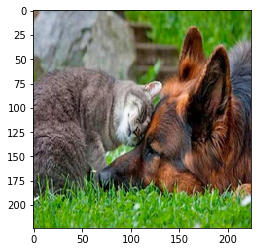

54.56% : timber_wolf
15.09% : coyote
13.45% : red_wolf
 6.30% : wombat
 3.05% : white_wolf


In [19]:
href = 'https://img.pravda.ru/image/preview/article/3/6/4/1042364_five.jpeg'

path = save_image(href, 'cat_dog_full.jpg')
predict(path)

Немного перепишем функцию для прогнозирования, добавив в неё resize 

In [20]:
def predict(image_path):
    # Подгружаем изображение и делаем его ресайз в соответсвии с моделью
    img = PIL.Image.open(image_path)
    
    # переделали в массив, обрезали 
    img = image_center_crop(np.array(img)) 
    
    # вернули назад в картинку, сделали resize 
    img_resized = PIL.Image.fromarray(img).resize(input_shape)

    # Рисуем картинку
    plt.imshow(img_resized)
    plt.show()

    # Кнвертируем картинку в numpy и делаем лишнюю размерность
    img_array = np.array(img_resized)[np.newaxis, ...]

    # VGG-16 строит нам прогноз
    pred = model.predict(img_array)
    
    # Декодируем прогноз
    pred_decoded = decode_predictions(pred)[0]

    # Печатаем его на экран
    for code, name, score in pred_decoded:
        print("{0:>6.2%} : {1}".format(score, name))

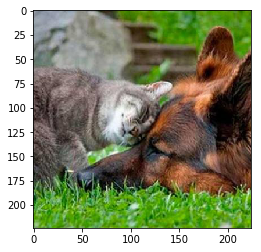

22.89% : wombat
21.85% : timber_wolf
16.65% : brown_bear
10.17% : cougar
 5.63% : ice_bear


In [21]:
href = 'https://img.pravda.ru/image/preview/article/3/6/4/1042364_five.jpeg'

path = save_image(href, 'cat_dog_full.jpg')
predict(path)

## 2. Другие обитатели зоопарка

И многие-многие другие! :) Какие-то из моделей довольно тяжёлые и много весят. Будьте осторожны при их подгрузке. 